In [21]:
import requests
import yaml
import json
import pandas as pd
import os

RESULTS_DIR = os.path.join(os.getcwd(), 'results')
QUERIES_DIR = os.path.join(os.getcwd(), 'queries')

##############################################################################################################################
# Toggle the below boolean to change whether the program fetches queries (false) or loads pre-fetched data (true)
LOAD_FROM_FILE = True
##############################################################################################################################

with open('api.yaml', 'r') as f:
    parsed_yaml = yaml.load(f, Loader=yaml.FullLoader)
    API_KEY = parsed_yaml['api']

def run_query(query):  # A simple function to use requests.post to make the API call.
    headers = {'X-API-KEY': 'API_KEY'}
    request = requests.post('https://graphql.bitquery.io/', json={'query': query, 'variables': variables},
                            headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code, query))


def write_json_to_file(json_obj, file):
    with open(file, 'w') as f_out:
        json.dump(json_obj, f_out)


def load_json_from_file(file):
    with open(file, 'r') as f_in:
        json_obj = json.load(f_in)
    return json_obj

#### This query returns the average transaction cost in ethereum chain

In [22]:
variables = {
  "limit": 10,
  "offset": 0,
  "network": "ethereum",
  "from": "2021-01-01",
  "till": "2022-05-24T23:59:59",
  "dateFormat": "%Y-%m"
}

query1 = """
query ($network: EthereumNetwork!, $dateFormat: String!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    transactions(options: {asc: "date.date"}, date: {since: $from, till: $till}) {
      date: date {
        date(format: $dateFormat)
      }
      gasPrice
      gasValue
      average: gasValue(calculate: average)
      maxGasPrice: gasPrice(calculate: maximum)
      medianGasPrice: gasPrice(calculate: median)
    }
  }
}


"""
if not LOAD_FROM_FILE:
    result1 = run_query(query1)  # Execute the query
    write_json_to_file(result1, os.path.join(QUERIES_DIR, 'query6.json'))
else:
    result1 = load_json_from_file(os.path.join(QUERIES_DIR, 'query6.json'))

print('Result - {}'.format(result1))


Result - {'data': {'ethereum': {'transactions': [{'date': {'date': '2021-01'}, 'gasPrice': 113.37837972829479, 'gasValue': 273504.33060019196, 'average': 0.007295246170121539, 'maxGasPrice': 852470.343401472, 'medianGasPrice': 88.000004096}, {'date': {'date': '2021-02'}, 'gasPrice': 191.68044239538312, 'gasValue': 423959.58427347674, 'average': 0.011916168293064184, 'maxGasPrice': 500801.004896256, 'medianGasPrice': 166.999998464}, {'date': {'date': '2021-03'}, 'gasPrice': 152.2816285089659, 'gasValue': 373341.95806983806, 'average': 0.009515187942577288, 'maxGasPrice': 448763.919335424, 'medianGasPrice': 140.999999488}, {'date': {'date': '2021-04'}, 'gasPrice': 128.30930618853526, 'gasValue': 316327.23576734005, 'average': 0.007575570363848727, 'maxGasPrice': 122448.980738048, 'medianGasPrice': 117.000003584}, {'date': {'date': '2021-05'}, 'gasPrice': 109.20976944895583, 'gasValue': 309860.04354056524, 'average': 0.006877366656112877, 'maxGasPrice': 217523.031113728, 'medianGasPrice':

In [24]:
# Convert the result to a dataframe
df1 = pd.json_normalize(result1['data']['ethereum']['transactions'])
df1.head(17)


,gasPrice,gasValue,average,maxGasPrice,medianGasPrice,date.date
0,113.378380,273504.330600,0.007295,8.524703e+05,88.000004,2021-01
1,191.680442,423959.584273,0.011916,5.008010e+05,166.999998,2021-02
2,152.281629,373341.958070,0.009515,4.487639e+05,140.999999,2021-03
3,128.309306,316327.235767,0.007576,1.224490e+05,117.000004,2021-04
4,109.209769,309860.043541,0.006877,2.175230e+05,69.631926,2021-05
5,27.207982,71927.595088,0.001987,1.634385e+05,20.000000,2021-06
6,32.688747,93870.231789,0.002505,1.135072e+05,25.999999,2021-07
7,67.030280,219391.359895,0.005890,3.000000e+05,51.999998,2021-08
8,103.554782,316734.875035,0.008895,5.324367e+07,80.073179,2021-09
9,118.209259,353364.329784,0.009075,1.442244e+06,99.814285,2021-10


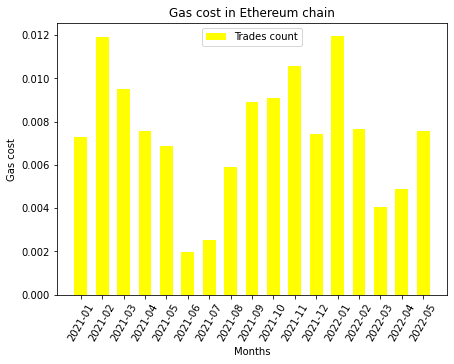

In [26]:
import matplotlib.pyplot as plt

cost = df1["average"]
date = df1["date.date"]

fig = plt.figure(figsize = (7, 5))
plt.bar(date, cost, color ='yellow',
        width = 0.6, label = "Trades count")

plt.xticks(rotation=60)
plt.xlabel("Months")
plt.ylabel("Gas cost")
plt.title("Gas cost in Ethereum chain")
plt.legend(loc= "upper center")
plt.show()

#### This query returns the average transaction cost in the binance smart chain

In [27]:
variables = {
  "limit": 10,
  "offset": 0,
  "network": "bsc",
  "from": "2021-01-01",
  "till": "2022-05-24T23:59:59",
  "dateFormat": "%Y-%m"
}

query2 = """
query ($network: EthereumNetwork!, $dateFormat: String!, $from: ISO8601DateTime, $till: ISO8601DateTime) {
  ethereum(network: $network) {
    transactions(options: {asc: "date.date"}, date: {since: $from, till: $till}) {
      date: date {
        date(format: $dateFormat)
      }
      gasPrice
      gasValue
      average: gasValue(calculate: average)
      maxGasPrice: gasPrice(calculate: maximum)
      medianGasPrice: gasPrice(calculate: median)
    }
  }
}



"""
if not LOAD_FROM_FILE:
    result2 = run_query(query2)  # Execute the query
    write_json_to_file(result2, os.path.join(QUERIES_DIR, 'query7.json'))
else:
    result2 = load_json_from_file(os.path.join(QUERIES_DIR, 'query7.json'))

print('Result - {}'.format(result2))

Result - {'data': {'ethereum': {'transactions': [{'date': {'date': '2021-01'}, 'gasPrice': 21.870199448472015, 'gasValue': 29792.865896690048, 'average': 0.002321787485677457, 'maxGasPrice': 190476.195987456, 'medianGasPrice': 20.0}, {'date': {'date': '2021-02'}, 'gasPrice': 16.671232048186567, 'gasValue': 87618.1797714013, 'average': 0.0016884277010606387, 'maxGasPrice': 999999.986991104, 'medianGasPrice': 10.0}, {'date': {'date': '2021-03'}, 'gasPrice': 14.032764682210917, 'gasValue': 119843.90414876472, 'average': 0.0014198094900079272, 'maxGasPrice': 400000.001507328, 'medianGasPrice': 10.0}, {'date': {'date': '2021-04'}, 'gasPrice': 8.665890511041058, 'gasValue': 157322.00010819413, 'average': 0.0009301225254607553, 'maxGasPrice': 333777.00806656, 'medianGasPrice': 5.0}, {'date': {'date': '2021-05'}, 'gasPrice': 7.859034367918531, 'gasValue': 224445.8016508567, 'average': 0.0009070371772128176, 'maxGasPrice': 104999.9966208, 'medianGasPrice': 5.0}, {'date': {'date': '2021-06'}, 'g

In [31]:
# Convert the result to a dataframe
df2 = pd.json_normalize(result2['data']['ethereum']['transactions'])
df2.head(17)


,gasPrice,gasValue,average,maxGasPrice,medianGasPrice,date.date
0,21.870199,29792.865897,0.002322,1.904762e+05,20.0,2021-01
1,16.671232,87618.179771,0.001688,1.000000e+06,10.0,2021-02
2,14.032765,119843.904149,0.001420,4.000000e+05,10.0,2021-03
3,8.665891,157322.000108,0.000930,3.337770e+05,5.0,2021-04
4,7.859034,224445.801651,0.000907,1.050000e+05,5.0,2021-05
5,7.425057,123354.184730,0.000945,4.700000e+04,5.0,2021-06
6,7.052818,180316.981051,0.000991,5.629757e+04,5.0,2021-07
7,6.092593,211297.280242,0.000882,1.041334e+05,5.0,2021-08
8,6.492751,148965.607182,0.000834,1.092152e+06,5.0,2021-09
9,6.306159,198130.688619,0.000824,1.223548e+06,5.0,2021-10


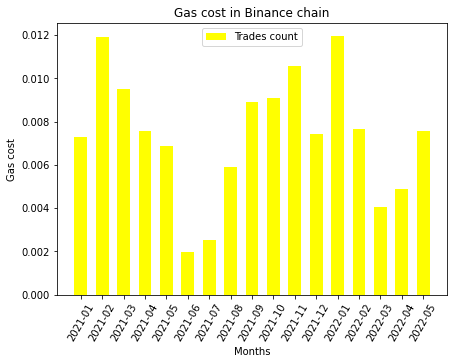

In [32]:
import matplotlib.pyplot as plt

cost = df1["average"]
date = df1["date.date"]

fig = plt.figure(figsize = (7, 5))
plt.bar(date, cost, color ='yellow',
        width = 0.6, label = "Trades count")

plt.xticks(rotation=60)
plt.xlabel("Months")
plt.ylabel("Gas cost")
plt.title("Gas cost in Binance chain")
plt.legend(loc= "upper center")
plt.show()